## Larissa de Santi -  Challenge 4: Crop Questions Analysis

This analysis addresses Challenge 4 by developing a **monolingual clustering pipeline** to establish topic categories for the large multilingual question dataset. The initial approach using cross-lingual embeddings failed, as the model incorrectly grouped questions primarily by language (English vs. local languages like Nyn and Luganda), demonstrating the challenge of semantic alignment across low-resource languages.

To overcome this, the workflow was restructured:
* **Translation**: All multilingual questions were unified by translation into English, implementing the translation pipeline developed in Challenge 0 by Anusha Dixit.
* **Embedding**: The unified English text was converted into 768-dimensional numerical vectors (embeddings) using the *paraphrase-multilingual-mpnet-base-v2* model.
* **Clustering**: K-Means clustering (K=7) was applied to the unified English embeddings to perform topic discovery.
* **Dimensionality Reduction and Visualization**: UMAP was used to reduce the high-dimensional embeddings to 2D coordinates for visual interpretation of the clusters and binary categories (crop-specific or general).

This pipeline provides the foundation for defining the topic labels needed for the "Crop-Specific vs. General" classification task.

---

### Workflow

#### 1. Imports and Setups
First, all necessary Python libraries are imported and global constants are defined.

In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from umap import UMAP
from transformers import pipeline
from tqdm import tqdm

# Set up constants
FILE_PATH = 'producers_direct_dataset.csv' 
QUESTION_ID_COL = 'question_id'
QUESTION_CONTENT_COL = 'question_content'
LANGUAGE_COL = 'question_language'
SENT_DATE_COL = 'question_sent' 

# Input/output columns
USE_COLS = [QUESTION_ID_COL, QUESTION_CONTENT_COL, LANGUAGE_COL, SENT_DATE_COL]
TEXT_INPUT_COL = 'translated_en' # The final unified column

# Analysis parameters
MODEL_NAME = 'paraphrase-multilingual-mpnet-base-v2' 
BATCH_SIZE = 32
SAMPLE_ROWS_TO_READ = 10000 

# Stability fix for downloads
os.environ['SENTENCE_TRANSFORMERS_DOWNLOAD_TIMEOUT'] = '60'

# Register tqdm with pandas for progress bars
tqdm.pandas()

# Define the file path for saving embeddings
EMBEDDINGS_FILE = 'monolingual_embeddings.npy'

#### 2. Data Loading and Translation
This is the most time-consuming step: it reads the raw multilingual dataset, performs cleaning, and then translates all Swahili, Luganda, and Nyanja questions to English. The result is the *MONOLINGUAL_DF*, which unifies the text for the subsequent monolingual analysis.

**Run this code cell only once**. After the initial run, load the saved *monolingual_translated_data.csv* file in the next cell to avoid rerunning the translation process.

In [ ]:
## Run only ONCE 

# Load data sample
print(f"Reading {SAMPLE_ROWS_TO_READ} rows and preparing monolingual subset...")
df = pd.read_csv(
    FILE_PATH, 
    usecols=USE_COLS, 
    nrows=SAMPLE_ROWS_TO_READ
)

# Deduplication and initial cleaning
df = df.drop_duplicates(subset=[QUESTION_ID_COL])
df[QUESTION_CONTENT_COL] = df[QUESTION_CONTENT_COL].fillna('').astype(str)

# Text cleaning function (removes symbols, lowercases)
def clean_text_for_translation(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_question'] = df[QUESTION_CONTENT_COL].progress_apply(clean_text_for_translation)

# Load translation models
print("\nLoading translation models...")

translator_lug = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="lug_Latn", tgt_lang="eng_Latn")
translator_swa = pipeline("translation", model="Helsinki-NLP/opus-mt-swc-en")
translator_nyn = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="nya_Latn", tgt_lang="eng_Latn")
print("Translation models loaded.")

# Translation logic
langs = {'swa': translator_swa, 'lug': translator_lug, 'nyn': translator_nyn}
df[TEXT_INPUT_COL] = pd.NA

for lang_code, translator in langs.items():
    subset_indices = df[df[LANGUAGE_COL] == lang_code].index
    texts = df.loc[subset_indices, 'clean_question'].tolist()

    translated_texts = []
    
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc=f"Translating {lang_code}"):
        batch = texts[i:i + BATCH_SIZE]
        try:
            outputs = translator(batch)
            translated_texts.extend([x['translation_text'] for x in outputs])
        except Exception as e:
            # Fallback to original text on failure (keeping the raw text)
            translated_texts.extend(batch) 

    df.loc[subset_indices, TEXT_INPUT_COL] = translated_texts


# Final unification (filling original English rows and combining)
df[TEXT_INPUT_COL] = df[TEXT_INPUT_COL].fillna(df['clean_question'])

MONOLINGUAL_DF = df # The full sample df is now the monolingual input

TRANSLATED_FILE = 'monolingual_translated_data.csv'
MONOLINGUAL_DF.to_csv(TRANSLATED_FILE, index=False)
print(f"Translated DataFrame saved to {TRANSLATED_FILE}")

print("\nTranslation pipeline complete. Data is unified for monolingual cClustering.")
print(f"Final monolingual input size: {len(MONOLINGUAL_DF):,} unique questions.")


In [ ]:
# Load saved translated data
TRANSLATED_FILE = 'monolingual_translated_data.csv'

try:
    MONOLINGUAL_DF = pd.read_csv(TRANSLATED_FILE)
    print(f"Successfully loaded MONOLINGUAL_DF from {TRANSLATED_FILE}")
    print(f"Loaded size: {len(MONOLINGUAL_DF):,} questions.")
except FileNotFoundError:
    print(f"ERROR: Translated file not found. Please run the 'Data Loading and Translation' cell (Cell 6) once to generate {TRANSLATED_FILE}.")

#### 3. Embedding
In this step, the *paraphrase-multilingual-mpnet-base-v2* model is loaded, which converts the unified English text into 768-dimensional numerical vectors (embeddings). These embeddings are then saved to a file (monolingual_embeddings.npy). 

This step must be **run only once**, because saving the embeddings to disk means all subsequent clustering analyses can bypass embedding generation steps.

In [ ]:
## Run only ONCE 

# Load MPNet model (feature extractor)
print(f"Loading sentence embedding model: {MODEL_NAME}...")
embedding_model = SentenceTransformer(MODEL_NAME)

# Generate embeddings using the clean translated text
print("Generating embeddings...")
monolingual_embeddings = embedding_model.encode(
    MONOLINGUAL_DF[TEXT_INPUT_COL].tolist(), 
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size=BATCH_SIZE 
)
print(f"Embeddings shape: {monolingual_embeddings.shape}") 

# Save embeddings
np.save(EMBEDDINGS_FILE, monolingual_embeddings)
print(f"Embeddings saved to {EMBEDDINGS_FILE}.")

#### 4. Clustering, UMAP and Visualization
This iterative analysis cell loads the saved embeddings and applies the K-Means algorithm to generate the final topic labels, followed by UMAP dimensionality reduction to prepare the data for a 2D visualization plot .

In [ ]:
# Anaysis parameter (use this cell to test new K)
K_CLUSTERS = 7

# Load saved embeddings
monolingual_embeddings = np.load(EMBEDDINGS_FILE)
print(f"Embeddings loaded successfully from {EMBEDDINGS_FILE}.")

# Applying K-Means clustering
print(f"\n--- Applying K-Means clustering (K={K_CLUSTERS}) ---")
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto', verbose=0)

# Attach cluster labels to the df
MONOLINGUAL_DF['topic_cluster'] = kmeans.fit_predict(monolingual_embeddings)
print("Clustering complete.")

# Applying UMAP for 2D visualization
print("Applying UMAP for 2D visualization...")
umap_2d = UMAP(n_components=2, random_state=42)
embeddings_2d = umap_2d.fit_transform(monolingual_embeddings)

# Attach UMAP coordinates to the df
MONOLINGUAL_DF['umap_x'] = embeddings_2d[:, 0]
MONOLINGUAL_DF['umap_y'] = embeddings_2d[:, 1]
print("UMAP reduction complete. Data is ready for interpretation.")

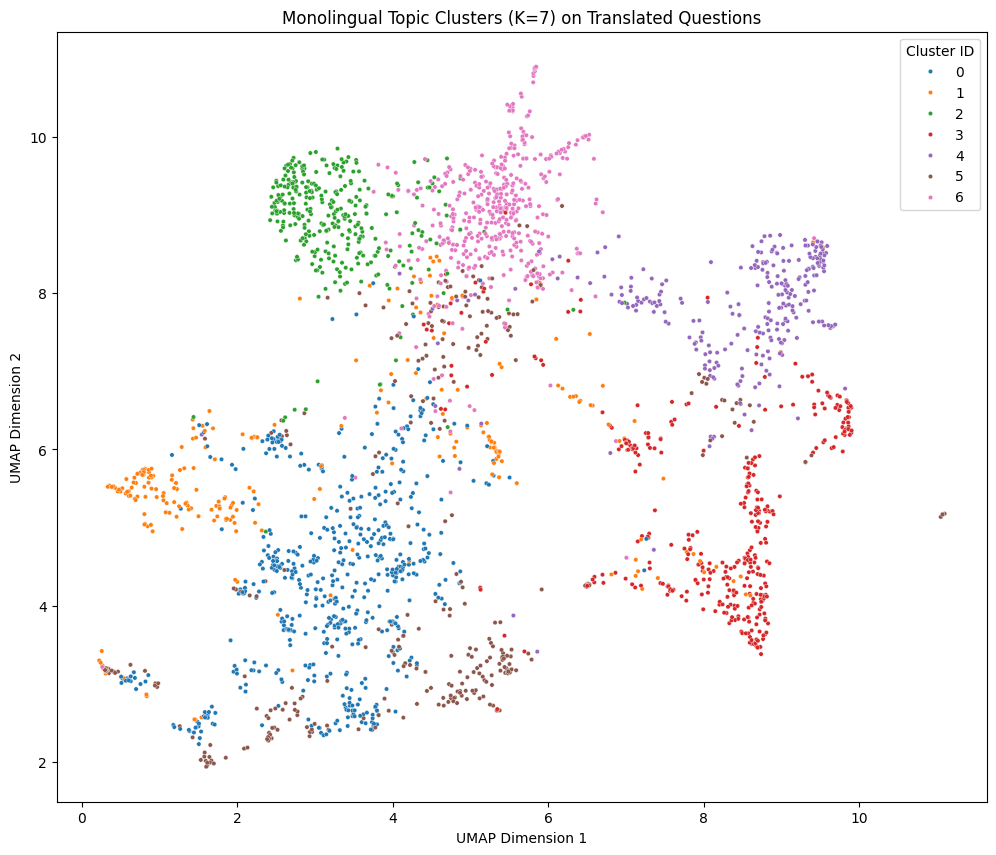


--- Monolingual cluster interpretation: Top questions ---

Cluster ID 0 (Size: 722 questions):
  Original language mix: {'eng': '79.4%', 'swa': '18.3%', 'nyn': '1.2%', 'lug': '1.1%'}
  Top 5 translated questions:
  - [Original: ENG] where do i get seeds of coconut...
  - [Original: ENG] qwhich plant has omega3...
  - [Original: ENG] q am jackson from ibanda if want to grow tomatoes on alarge scale which season can i use to target a...
  - [Original: ENG] what are the effects of animal waste on potato if aplied during planting...
  - [Original: ENG] how can i raise coffee plants from seedling...

Cluster ID 6 (Size: 559 questions):
  Original language mix: {'nyn': '58.9%', 'swa': '27.0%', 'eng': '11.1%', 'lug': '3.0%'}
  Top 5 translated questions:
  - [Original: NYN] In the same way, in the same way, in the same way, in the same way, in the same way, in the same way...
  - [Original: NYN] e radio broadcasts we take out the existing stations the radio broadcasts and when they are loade

In [7]:
# Visualization: clusters

plt.figure(figsize=(12, 10))

sns.scatterplot(
    x='umap_x', 
    y='umap_y', 
    hue='topic_cluster', 
    data=MONOLINGUAL_DF.sample(frac=0.8, random_state=42), 
    palette=sns.color_palette("tab10", K_CLUSTERS),
    legend=True,
    s=10
)

plt.title(f'Monolingual Topic Clusters (K={K_CLUSTERS}) on Translated Questions')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster ID')
plt.show()

# Preparation for manual labeling (Crop-Specific vs. General)
top_clusters = MONOLINGUAL_DF['topic_cluster'].value_counts().nlargest(K_CLUSTERS).index

print("\n--- Monolingual cluster interpretation: Top questions ---")
for cluster_id in top_clusters:
    cluster_questions = MONOLINGUAL_DF[MONOLINGUAL_DF['topic_cluster'] == cluster_id]
    
    print(f"\nCluster ID {cluster_id} (Size: {len(cluster_questions):,} questions):")
    
    # Show original language distribution
    lang_dist = cluster_questions[LANGUAGE_COL].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    print(f"  Original language mix: {lang_dist.to_dict()}")
    
    # Show the content of the top 5 questions from the unified text column
    print("  Top 5 translated questions:")
    for i, row in cluster_questions.head(5).iterrows():
        print(f"  - [Original: {row[LANGUAGE_COL].upper()}] {row[TEXT_INPUT_COL][:100]}...")

In [ ]:
# Define the mapping
def map_to_binary_label(cluster_id):
    """Maps the cluster ID to the final binary classification."""
    if cluster_id in [0, 5]:
        # Cluster 0: Production, Cluster 5: Pest/Disease
        return 'Crop-Specific'
    else:
        # Clusters 1 (Market), 3 (Poultry), 4 (Livestock), 2 (Poor Translation Noise), 6 (Noise)
        return 'General/Livelihood'

# Apply the mapping to create the new binary column
MONOLINGUAL_DF['binary_topic'] = MONOLINGUAL_DF['topic_cluster'].apply(map_to_binary_label)

# Calculate the final counts and proportions
final_counts = MONOLINGUAL_DF['binary_topic'].value_counts()
final_proportions = MONOLINGUAL_DF['binary_topic'].value_counts(normalize=True).mul(100).round(2)

print("\n--- Final Binary Topic Counts ---")
print(final_counts)
print("\n--- Final Binary Topic Proportions (%) ---")
print(final_proportions)

# Create bar plot
plt.figure(figsize=(8, 6))

# Define colors
custom_palette = {'Crop-Specific': "#9218b1", 'General/Livelihood': '#ff7f0e'}

# Use the index from final_counts for the x-axis to maintain sort order
sns.barplot(x=final_counts.index, y=final_counts.values, palette=[custom_palette.get(x) for x in final_counts.index])

# Add percentage labels on top of the bars
for i, count in enumerate(final_counts.values):
    proportion = final_proportions.loc[final_counts.index[i]]
    plt.text(i, count + 50, f'{proportion:.2f}%', ha='center', fontsize=12)

plt.title('Proportion of Farmer Questions: Crop-Specific vs. General')
plt.xlabel('Topic Category')
plt.ylabel('Number of Questions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('binary_topic_proportion.png')
plt.show()

# Final insight
crop_prop = final_proportions['Crop-Specific']
general_prop = final_proportions['General/Livelihood']

print(f"\n--- Final Insight ---")
print(f"The analysis found that {crop_prop:.2f}% of the unique questions are Crop-Specific, ")
print(f"while {general_prop:.2f}% are related to General/Livelihood topics (including livestock, markets, and translation noise).")

Generating word clouds...


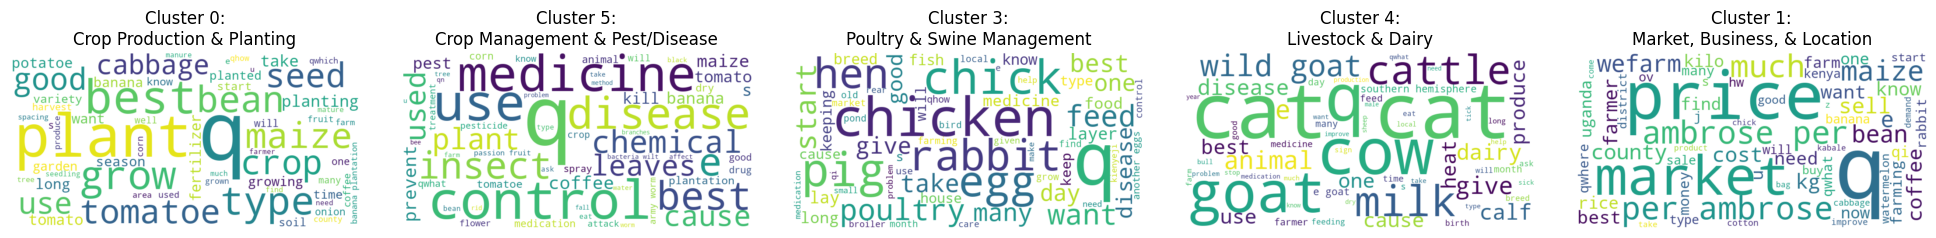

In [13]:
## Visualization: word cloud

# Map cluster IDs
clusters_to_visualize = {
    0: "Crop Production & Planting",
    5: "Crop Management & Pest/Disease",
    3: "Poultry & Swine Management",
    4: "Livestock & Dairy",
    1: "Market, Business, & Location"
}

# Setup the visualization grid
num_plots = len(clusters_to_visualize)
fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 6))

print("Generating word clouds...")

for i, (cluster_id, label) in enumerate(clusters_to_visualize.items()):
    # Filter the df for the current cluster ID
    cluster_df = MONOLINGUAL_DF[MONOLINGUAL_DF['topic_cluster'] == cluster_id]
    
    # Combine all text into a single string
    text = " ".join(cluster_df[TEXT_INPUT_COL].dropna().tolist())
    
    # Generate the word cloud object
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=60,
        colormap='viridis'
    ).generate(text)
    
    # Create the word cloud
    ax = axes[i] 
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Cluster {cluster_id}:\n{label}", fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()

---
### Summary
The iterative K-Means clustering analysis successfully identified K=7 as the optimal solution for generating topic labels from the translated question data. This configuration and the translation pipeline effectively overcame the initial problem of language-based grouping that occurred when using cross-lingual models on the multilingual dataset. 

The seven semantic clusters separated the 3,265 unique translated questions into five agricultural topics (three general/non-crop and two crop-specific) and two clusters designated as noise.

| Cluster ID | Inferred Topic Label | Core Content Focus | Binary Classification |
| :---: | :--- | :--- | :--- |
| **0** | Crop Production & Planting | Seeking **seeds**, ideal **seasons**, general cultivation, and raising seedlings (e.g., coconut, tomatoes, coffee) | Crop-Specific |
| **5** | Crop Management & Pest/Disease | Controlling **pests** (**army worm**), treating **plant diseases** (banana wilt, coffee diseases), and managing chemical inputs (NPK/fertilizers) | Crop-Specific |
| **4** | Livestock & Dairy | Management of cows, maximizing **milk yield**, general cattle health | General |
| **3** | Poultry & Swine Management | Questions about **chickens**, chicks, pigs, and treatment of small animals | General |
| **1** | Market, Business & Location | Inquiries on product pricing, market access/logistics, finding offices/stores, and local geography | General |
| **6** | Noise (Repetitive / Low-Context) | Repetitive phrases and general low-context noise | Noise |
| **2** | Noise (Poor Nyanja Translation) | Unintelligible text, fragmentation (due to low-resource language translation) | Noise |

The analysis provides a necessary foundation for transforming the raw, multilingual WeFarm data into actionable insights that directly support the goals of Producers Direct. The seven-cluster topic model creates a coherent structure for understanding the diverse agricultural and livelihood challenges smallholder farmers are seeking support with.

Furthermore, the final results demonstrate that the Nyanja (Nyn) language subset contains unreliable data due to its poor translation quality for this low-resource language. Consequently, a required next step is to include a process of human validation on the Nyanja cluster to ensure the integrity of the final "General" question proportion and inform trustworthy strategic decisions.


---
### Acknowledgment
I acknowledge Anusha Dixit's work on the translation pipeline in Challenge 0, which was essential to this monolingual analysis.